In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Visualization:
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess:
from scipy import stats
from scipy.stats import norm,skew

# Preprocess & Regression Models:
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
import xgboost as xgb

<a id="1"></a>

# **LOAD and FIRST LOOK to DATA**

In [3]:
data=pd.read_csv("../input/auto-mpg-dataset/auto-mpg.csv")
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [5]:
data.shape

(398, 9)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


<a id="2"></a>

# **MISSING VALUES**

In [7]:
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

#### There seems to be no missing values in the dataset

In [8]:
data["horsepower"][data["horsepower"]=="?"].count()

6

### But we have 6 ? values in horsepower feature. Lets change ? values with mean.

In [9]:
data["horsepower"][data["horsepower"]=="?"]

32     ?
126    ?
330    ?
336    ?
354    ?
374    ?
Name: horsepower, dtype: object

In [10]:
# Replace ? values with NaN
for i in data["horsepower"]:
    if (i=="?"):
        data["horsepower"]=data["horsepower"].replace("?",np.NaN)
data["horsepower"].isnull().sum()

6

In [11]:
# Type of horsepower is object. Lets convert it to float
data["horsepower"]=data["horsepower"].astype(np.float64)

In [12]:
# Impute NaN values with mean.
data["horsepower"]=data["horsepower"].fillna(data["horsepower"].mean())

In [13]:
# Last check:
data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

<a id="3"></a>

# **EXPLORATORY DATA ANALYSIS**

In [14]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [15]:
fig=px.histogram(data,x="car name",title="Number of Cars")
fig.show()

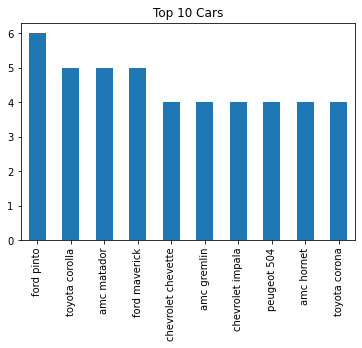

In [16]:
data["car name"].value_counts()[0:10].plot.bar().set_title("Top 10 Cars");

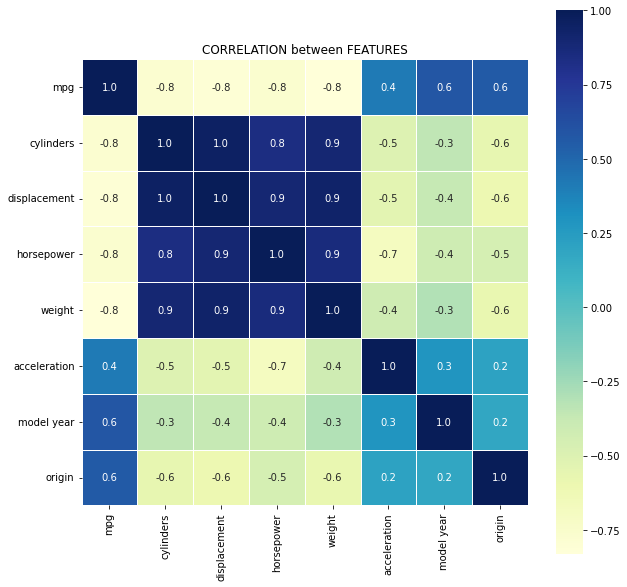

In [17]:
corr=data.corr()
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(corr,annot=True,linewidths=0.5,fmt=".1f",ax=ax,cmap="YlGnBu",square=True)
plt.title("CORRELATION between FEATURES")
plt.show()

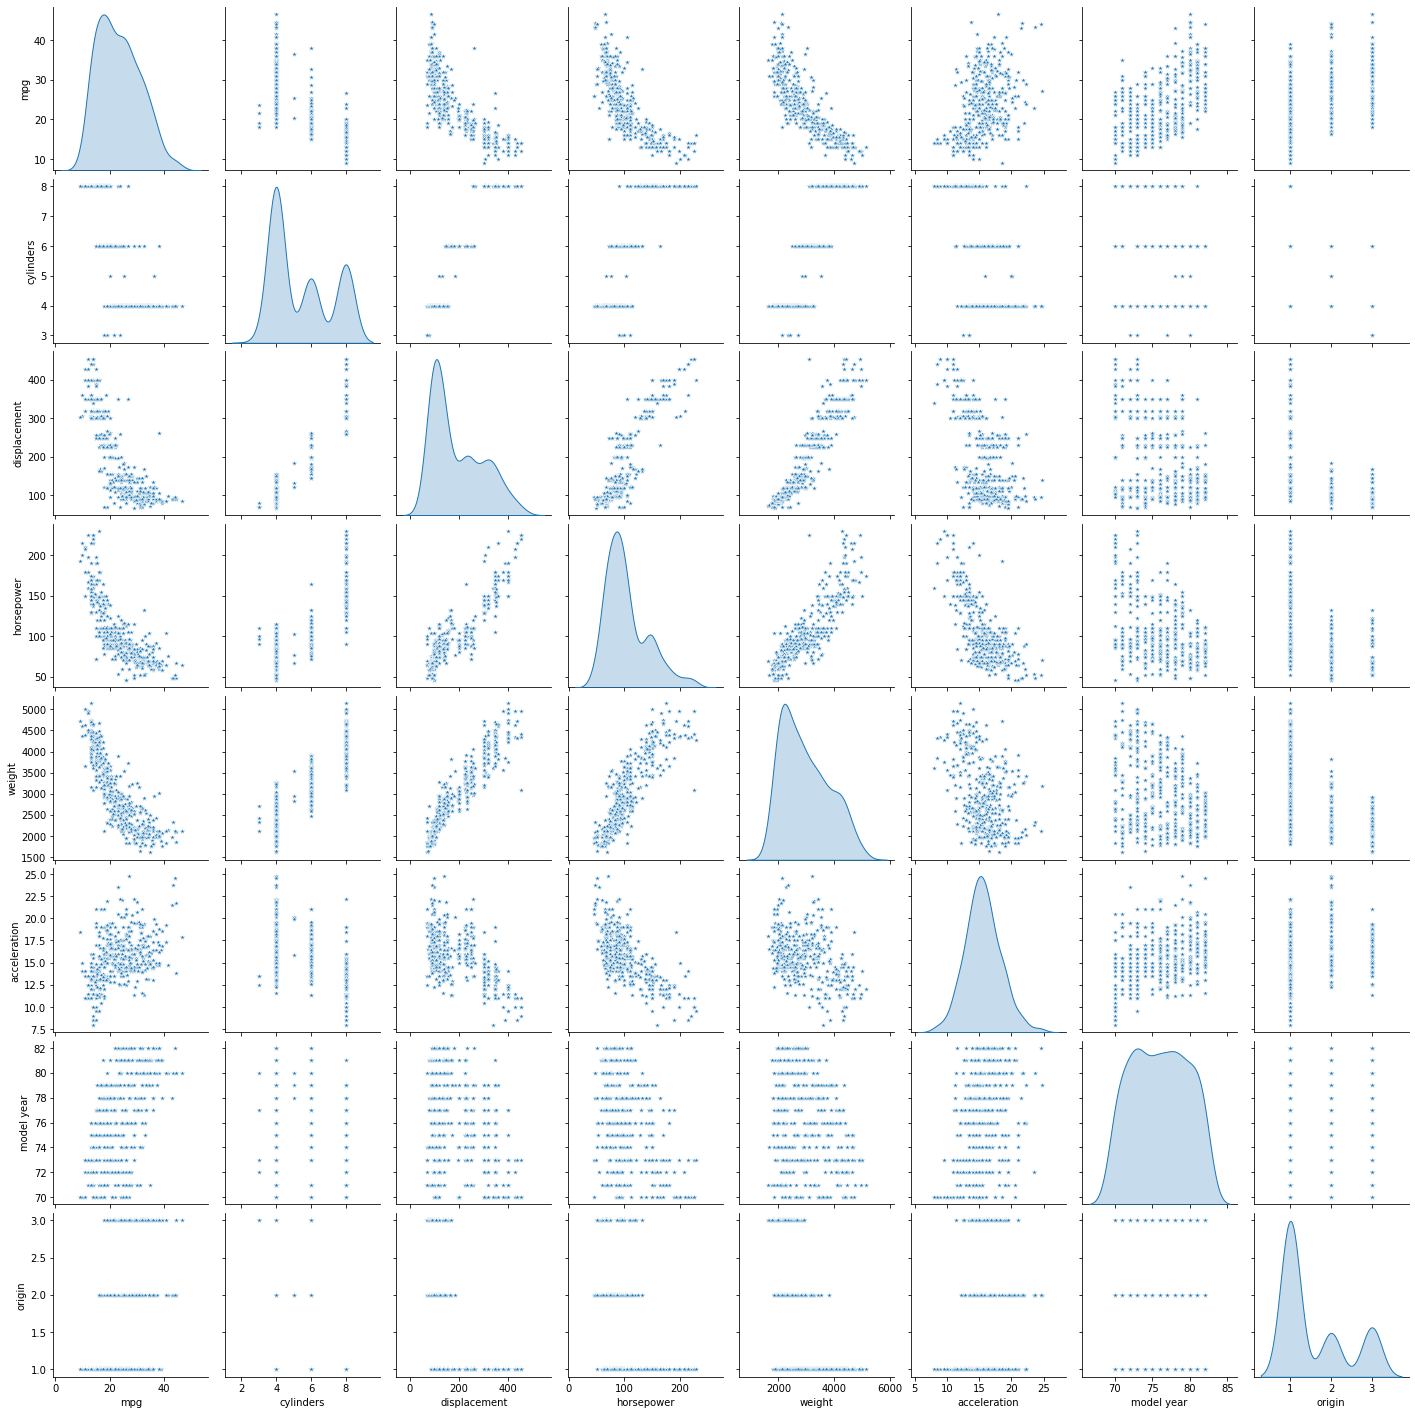

In [18]:
sns.pairplot(data,diag_kind="kde",markers="*");

In [19]:
fig = go.Figure()
fig.add_trace(go.Box(
    y=data.mpg,
    name="MPG",
    boxpoints="suspectedoutliers",
    marker_color="rgb(7,40,89)",
    line_color="rgb(7,40,89)"
))
fig.add_trace(go.Box(
    y=data.cylinders,
    name="CYLINDERS",
    boxpoints="suspectedoutliers",
    marker_color='rgb(9,56,125)',
    line_color='rgb(9,56,125)'
))

fig.add_trace(go.Box(
    y=data.horsepower,
    name="HORSEPOWER",
    boxpoints="suspectedoutliers",
    marker_color='rgb(107,174,214)',
    line_color='rgb(107,174,214)'
))
fig.add_trace(go.Box(
    y=data.acceleration,
    name="ACCELERATION",
    boxpoints="suspectedoutliers",
    marker_color='rgb(8,81,156)',
    line_color='rgb(8,81,156)'
))
fig.show()

<a id="4"></a>

# **OUTLIERS**

In [20]:
horsepowerQ1=data["horsepower"].quantile(0.25)
horsepowerQ3=data["horsepower"].quantile(0.75)
horsepowerIQR=horsepowerQ3-horsepowerQ1
print("First Quartile: ",horsepowerQ1)
print("Third Quartile: ",horsepowerQ3)
print("Interquartile: ",horsepowerIQR)
print("*********************************************************")
HPlower_limit=horsepowerQ1-1.5*horsepowerIQR
HPupper_limit=horsepowerQ3+1.5*horsepowerIQR
print("Lower Limit: ",HPlower_limit)
print("Upper Limi: ",HPupper_limit)

First Quartile:  76.0
Third Quartile:  125.0
Interquartile:  49.0
*********************************************************
Lower Limit:  2.5
Upper Limi:  198.5


In [21]:
filter_lower=HPlower_limit<data["horsepower"]
filter_upper=data["horsepower"]<HPupper_limit
my_filter=filter_lower&filter_upper
data=data[my_filter]

In [22]:
accelerationQ1=data["acceleration"].quantile(0.25)
accelerationQ3=data["acceleration"].quantile(0.75)
accelerationIQR=accelerationQ3-accelerationQ1
print("First Quartile: ",accelerationQ1)
print("Third Quartile: ",accelerationQ3)
print("Interquartile: ",accelerationIQR)
print("*********************************************************")
Alower_limit=accelerationQ1-1.5*accelerationIQR
Aupper_limit=accelerationQ3+1.5*accelerationIQR
print("Lower Limit: ",Alower_limit)
print("Upper Limi: ",Aupper_limit)

First Quartile:  14.0
Third Quartile:  17.3
Interquartile:  3.3000000000000007
*********************************************************
Lower Limit:  9.049999999999999
Upper Limi:  22.25


In [23]:
filter_lower=Alower_limit<data["acceleration"]
filter_upper=data["acceleration"]<Aupper_limit
my_filter_acc=filter_lower&filter_upper
data=data[my_filter_acc]

<a id="5"></a>

# **FEATURE ENGINEERING**
    
   * Skewness
   * One-Hot Encoding

In [24]:
data=data.drop(["car name"],axis=1)
data.head(1)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1


<a id="6"></a>

## **SKEWNESS**

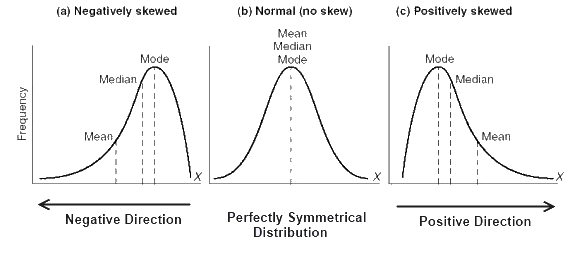

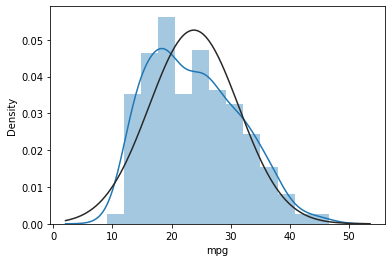

In [25]:
sns.distplot(data.mpg,fit=norm);

In [26]:
(mean,standard_deviation)=norm.fit(data["mpg"])
print("Mean: {}, Standard Deviation: {}".format(mean,standard_deviation))

Mean: 23.76167979002625, Standard Deviation: 7.58107889968785


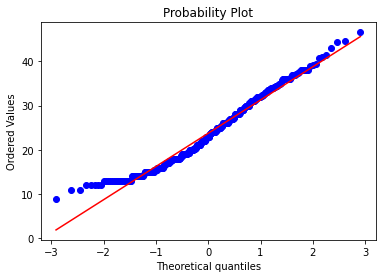

In [27]:
# QQ PLOT:
stats.probplot(data["mpg"],plot=plt)
plt.show()

Mean: 3.161688999706393, Standard Deviation: 0.3114096868725869


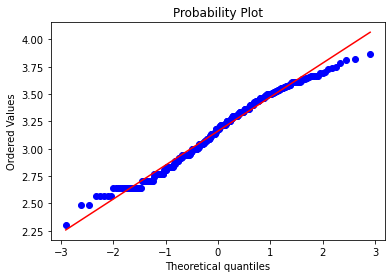

In [28]:
data["mpg"]=np.log1p(data["mpg"])


(mean,standard_deviation)=norm.fit(data["mpg"])
print("Mean: {}, Standard Deviation: {}".format(mean,standard_deviation))
stats.probplot(data["mpg"],plot=plt)
plt.show()

In [29]:
skewed=data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness=pd.DataFrame(skewed,columns=["Skewed"])
skewness

,Skewed
origin,0.882740
horsepower,0.855351
displacement,0.702323
cylinders,0.598230
weight,0.566934
acceleration,0.256853
model year,-0.010564
mpg,-0.113193


<a id="7"></a>

## **ONE-HOT ENCODING**

In [30]:
data["cylinders"]=data["cylinders"].astype(str)
data["origin"]=data["origin"].astype(str)

In [31]:
data=pd.get_dummies(data)
data.head()

,mpg,displacement,horsepower,weight,acceleration,model year,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3
0,2.944439,307.0,130.0,3504,12.0,70,0,0,0,0,1,1,0,0
1,2.772589,350.0,165.0,3693,11.5,70,0,0,0,0,1,1,0,0
2,2.944439,318.0,150.0,3436,11.0,70,0,0,0,0,1,1,0,0
3,2.833213,304.0,150.0,3433,12.0,70,0,0,0,0,1,1,0,0
4,2.890372,302.0,140.0,3449,10.5,70,0,0,0,0,1,1,0,0


<a id="8"></a>

# **PREPARATION for MODEL**

In [32]:
y=data.mpg
x=data.drop(["mpg"],axis=1)

In [33]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

<a id="9"></a>

## **STANDIZATION**

In [34]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

<a id="10"></a>

# **MODEL**

<a id="11"></a>

## **LINEAR REGRESSION**

In [35]:
lr=LinearRegression()
lr.fit(X_train,y_train)
print("Linear Regression Coef: ",lr.coef_)

Linear Regression Coef:  [ 0.04487254 -0.08796458 -0.17944479 -0.01284053  0.10024763 -0.01965341
  0.01728603  0.00518886 -0.02339673  0.00487837 -0.01437784  0.00721426
  0.01052337]


In [36]:
y_predicted=lr.predict(X_test)
linear_mse=mean_squared_error(y_test,y_predicted)
print("Mean Squared Error: ",linear_mse)

Mean Squared Error:  0.01217238018642711


<a id="12"></a>

## **RIDGE REGRESSION (L2)**

In [37]:
ridge=Ridge(random_state=42,max_iter=10000)


In [38]:
# Finding best hyperparameters:
alphas=np.logspace(-4,-0.5,30)
parameters=[{"alpha":alphas}]
CV_parameters=GridSearchCV(ridge,parameters,cv=5,scoring="neg_mean_squared_error",refit=True)
CV_parameters.fit(X_train,y_train)
scores=CV_parameters.cv_results_["mean_test_score"]

In [39]:
CV_parameters.best_params_

{'alpha': 0.31622776601683794}

In [40]:
CV_parameters.best_estimator_

Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)

In [41]:
CV_parameters.best_score_

-0.013420272026005675

In [42]:
ridge=CV_parameters.best_estimator_

In [43]:
y_predicted=CV_parameters.predict(X_test)
ridge_mse=mean_squared_error(y_test,y_predicted)
print("Mean Squared Error Ridge: ",ridge_mse)

Mean Squared Error Ridge:  0.012128419691363796


Text(0.5, 1.0, 'RIDGE')

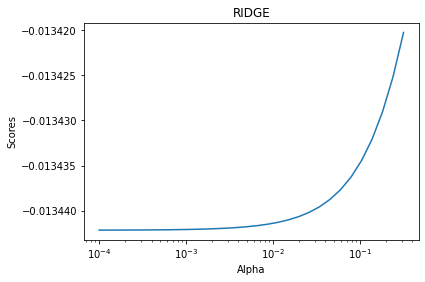

In [44]:
# Lets look change of alpha:
plt.figure()
plt.semilogx(alphas,scores)
plt.xlabel("Alpha")
plt.ylabel("Scores")
plt.title("RIDGE")

<a id="13"></a>

## **LASSO REGRESSION (L1)**

In [45]:
lasso=Lasso(random_state=42,max_iter=10000)

In [46]:
# Finding best hyperparameters:
alphas=np.logspace(-4,-0.5,30)
parameters=[{"alpha":alphas}]
CV_parameters=GridSearchCV(lasso,parameters,cv=5,scoring="neg_mean_squared_error",refit=True)
CV_parameters.fit(X_train,y_train)
scores=CV_parameters.cv_results_["mean_test_score"]

In [47]:
CV_parameters.best_params_

{'alpha': 0.008531678524172814}

In [48]:
CV_parameters.best_estimator_

Lasso(alpha=0.008531678524172814, max_iter=10000, random_state=42)

In [49]:
CV_parameters.best_score_

-0.012591885530576585

In [50]:
y_predicted=CV_parameters.predict(X_test)
lasso_mse=mean_squared_error(y_test,y_predicted)
print("Mean Squared Error Lasso: ",lasso_mse)

Mean Squared Error Lasso:  0.011231559232940702


Text(0.5, 1.0, 'LASSO')

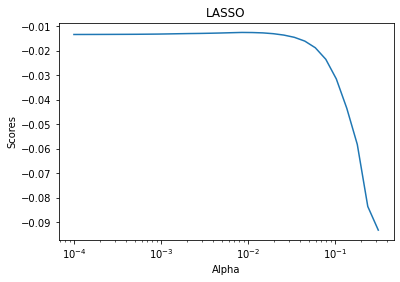

In [51]:
# Lets look change of alpha:
plt.figure()
plt.semilogx(alphas,scores)
plt.xlabel("Alpha")
plt.ylabel("Scores")
plt.title("LASSO")

<a id="14"></a>

# **ELASTIC NET REGRESSION**

In [52]:
paramsGrid={"alpha":alphas,
           "l1_ratio":np.arange(0.0,1.0,0.05)}

In [53]:
elNet=ElasticNet(random_state=42,max_iter=10000)
grid=GridSearchCV(elNet,paramsGrid,cv=5,scoring="neg_mean_squared_error",refit=True)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000, random_state=42),
             param_grid={'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01]),
                         'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring='neg_mean_squared_error')

In [54]:
grid.best_estimator_

ElasticNet(alpha=0.011264816923358867, l1_ratio=0.8, max_iter=10000,
           random_state=42)

In [55]:
grid.best_params_

{'alpha': 0.011264816923358867, 'l1_ratio': 0.8}

In [56]:
elNet=grid
y_predicted=grid.predict(X_test)
elNet_mse=mean_squared_error(y_test,y_predicted)
elNet_mse

0.011237425300747528

<a id="15"></a>

# **XGBoost Regression**

In [57]:
params_xgb={"nthread":[4],
           "objective":["reg:linear"],
           "max_depth":[5,6,7],
           "min_child_weight":[4],
           "silent":[1],
           "subsample":[0.7],
           "colsample_bytree":[0.7],
           "n_estimators":[500,1000]}

In [58]:
xgb_model=xgb.XGBRegressor(objective="reg:linear",max_depth=5,min_child_weight=4,subsample=0.7,n_estimators=1000,learning_rate=0.07)
xgb_model.fit(X_train,y_train)
y_predicted=xgb_model.predict(X_test)
XGB_mse=mean_squared_error(y_test,y_predicted)
XGB_mse

[07:27:27] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


0.011052611284803336

<a id="16"></a>

# **RESULTS**

In [59]:
results=pd.DataFrame({"Models":["Linear Regression","Ridge Regression","Lasso Regression","Elastic Net","XGBoost"],
                     "Values":[linear_mse,ridge_mse,lasso_mse,elNet_mse,XGB_mse]})
results

,Models,Values
0,Linear Regression,0.012172
1,Ridge Regression,0.012128
2,Lasso Regression,0.011232
3,Elastic Net,0.011237
4,XGBoost,0.011053


In [60]:
fig = px.bar(results, x='Values', y='Models',
             labels={'Mean Squared Error of Models'},
             hover_data=['Values', 'Models'], color='Models',
             height=400)
fig.show()